In [6]:
import xgboost as xgb

In [35]:
# inspired by https://www.kaggle.com/nickycan/lb-0-3805009-python-edition
import numpy as np   ## linear algebra
import pandas as pd  ## data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split  ## split train and test
from IPython.display import display ## Allows the use of display() for DataFrames

import matplotlib.pyplot as plt  ## data visualization

import gc   ## clean up 
import time ## time it

from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [64]:
import sklearn
import matplotlib
import seaborn
my_list = [np, pd, sklearn, matplotlib, seaborn ]

for this in my_list:
    print("{} version: {}".format(this.__name__, this.__version__))

#print(.__version__)

numpy version: 1.13.1
pandas version: 0.20.3
sklearn version: 0.19.0
matplotlib version: 2.0.2
seaborn version: 0.7.1


## Load the dataset from feature engineering ##

In [3]:
## access to hdf5 file
df_data = pd.read_hdf('saved_df_data_whole.h5', 'df_data')

In [5]:
display(df_data.head(5))
display(df_data.shape)

,user_id,product_id,_up_order_count,_up_first_order_number,_up_last_order_number,_up_average_cart_position,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_buy_first_time_total_cnt,_prod_buy_second_time_total_cnt,...,_user_total_products,_user_distinct_products,_user_average_basket,order_id,eval_set,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order,reordered
0,1,196,10,1,10,1.400000,35791,27791.0,8000,4660,...,59,18,5.9,1187899,train,14.0,1.0,0,1.000000,1.0
1,1,10258,9,2,10,3.333333,1946,1389.0,557,308,...,59,18,5.9,1187899,train,14.0,0.9,0,1.000000,1.0
2,1,10326,1,5,5,5.000000,5526,3603.0,1923,1003,...,59,18,5.9,1187899,train,14.0,0.1,5,0.166667,NaN
3,1,12427,10,1,10,3.300000,6476,4797.0,1679,889,...,59,18,5.9,1187899,train,14.0,1.0,0,1.000000,NaN
4,1,13032,3,2,10,6.333333,3751,2465.0,1286,617,...,59,18,5.9,1187899,train,14.0,0.3,0,0.333333,1.0


(13307953, 26)

In [ ]:
class setup_your_clock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))

### For Competition Submission ###

In [ ]:
def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, 
                                   methods_list, keep_only_stats=True, verbose=1):
    '''Create statistical columns, group by [N columns] and compute stats on [1 column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       target_columns_list: list_like
          column you want to compute stats, need to be a list with only one element
       methods_list: list_like
          methods that you want to use, all methods that supported by groupby in Pandas

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       ka_add_stats_features_n_vs_1(train, group_columns_list=['x0'], target_columns_list=['x10'])
    '''
    with setup_your_clock("add stats features", verbose):
        dicts = {"group_columns_list": group_columns_list , 
                 "target_columns_list": target_columns_list, 
                 "methods_list": methods_list}

        for k, v in dicts.items():
            try:
                if type(v) == list:
                    pass
                else:
                    raise TypeError(k + " should be a list")
            except TypeError as e:
                print(e)
                raise

        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]
        ##print(combine_name)
        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
        if keep_only_stats:
            return the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
        return df_new

## Train / Test ##

In [ ]:
print(df_data.columns)
print(df_data.shape)

In [10]:
df_train = df_data[df_data['eval_set'] == "train"].copy()
df_train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
df_train.loc[:, 'reordered'] = df_train.reordered.fillna(0)

In [ ]:
display(df_train.head(3))

### Normalization ###

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns = df_train.columns.values)


In [ ]:
display(df_train.head(3))

In [16]:
## X_test = df_data.loc[df_data.eval_set == "test",:]

X_df_train, X_val, y_df_train, y_val = train_test_split(df_train.drop('reordered', axis=1), df_train.reordered,
                                                    test_size=0.8, random_state=42)

In [ ]:
d_df_train = xgb.DMatrix(X_df_train, y_df_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

In [ ]:
watchlist= [(d_df_train, "train")]
bst = xgb.train(params=xgb_params, dtrain=d_df_train, num_boost_round=120, 
                evals=watchlist, verbose_eval=10)

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

plt.rcParams["figure.figsize"] = (8,6)
xgb.plot_importance(bst)
plt.tight_layout()
plt.savefig('./figures/fig_dominant_features_xgboost.png')
plt.show()

### Save the Model using Pickle ###

In [1]:
import pickle
saving_model = False

filename = 'm99_optimal_model.p'

if saving_model: 
    ## save the model to disk
    pickle.dump(bst, open(filename, 'wb'))
else:
    ## load the model from disk
    bst = pickle.load(open(filename, 'rb'))

/Users/udothemath1984/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [70]:
# display(X_val.head(3))
# display(y_val.head(3))

### Prediction ###

In [18]:
## get the right format for xgboost
xgboost_dtest=xgb.DMatrix(X_val)
## prediction
ypred2=bst.predict(xgboost_dtest)

In [86]:
# show_entries = 10
# print(ypred2[:show_entries])
# print(y_val[:show_entries])

### Modify the Skewed Data ###

In [ ]:
from scipy import stats
plt.clf()
#display(stats.describe(ypred2))
plt.hist(ypred2, bins='auto')
plt.show()

2.6082448959350586


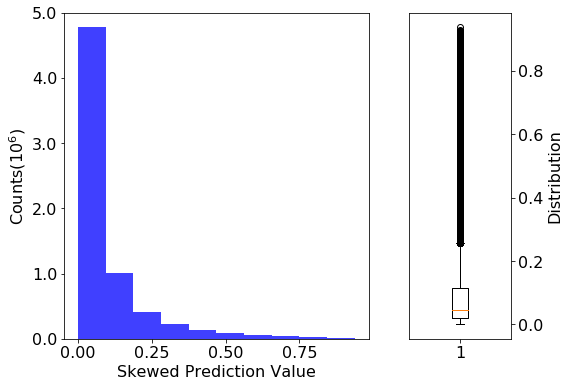

In [123]:
## http://shahramabyari.com/2015/12/21/data-preparation-for-predictive-modeling-resolving-skewness/
from scipy.stats import skew
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

y_unit = 1000000

def major_formatter(y, pos):
    return "{:.1f}".format(y/y_unit)

skness = skew(ypred2)
print(skness)
##We draw the histograms 
plt.clf()

# plot it
fig = plt.figure(figsize=(8, 6)) 
gs = GridSpec(1, 2, width_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
#ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0}'.format(y/y_unit)))
ax1.yaxis.set_major_formatter(FuncFormatter(major_formatter))
plt.hist(ypred2,facecolor='blue',alpha=0.75) 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
plt.xlabel("Skewed Prediction Value") 
plt.ylabel("Counts(10$^6$)") 
plt.ylim(0,5*y_unit)

#plt.title("Transformed AirTime Histogram") 
#plt.text(2,100000,"Skewness: {0:.2f}".format(skness)) 

#ax2 = plt.subplot(122)
ax2 = plt.subplot(gs[1])

plt.boxplot(ypred2)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.ylabel("Distribution") 

#plt.tight_layout()

#plt.title("Large Skewness shows Right Skewed Distribution")
plt.savefig('./figures/fig_skewed_raw.png')

plt.show()


In [124]:
# import pandas as pd
# import matplotlib.pylab as plt
from sklearn import preprocessing
# from scipy.stats import skew
# import numpy as np
from scipy.stats import boxcox

# #Note that we shift the values by 1 to get rid of zeros
ypred2_BoxCox = preprocessing.scale(boxcox(ypred2+1)[0])
ypred2_Orig = preprocessing.scale(ypred2)

#Next We calculate Skewness using skew in spicy.stats
skness_BoxCox = skew(ypred2_BoxCox)
skness_Orig = skew(ypred2_Orig)

/Users/udothemath1984/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/udothemath1984/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


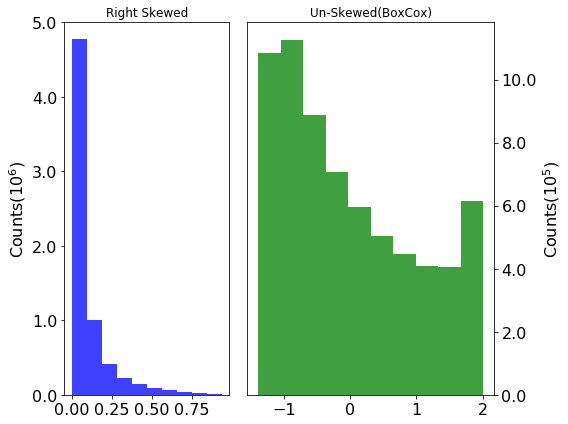

In [134]:
plt.clf()

y_left_unit = 1000000
def major_formatter_left(y, pos):
    return "{:.1f}".format(y/y_left_unit)

y_right_unit = 100000
def major_formatter_right(y, pos):
    return "{:.1f}".format(y/y_right_unit)

# plot it
fig = plt.figure(figsize=(8, 6)) 
gs = GridSpec(1, 2, width_ratios=[2, 3]) 
ax1 = plt.subplot(gs[0])
#ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0}'.format(y/y_unit)))
ax1.yaxis.set_major_formatter(FuncFormatter(major_formatter_left))
plt.hist(ypred2,facecolor='blue',alpha=0.75) 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
#plt.xlabel("Skewed Prediction Value") 
plt.ylabel("Counts(10$^6$)") 
plt.title("Right Skewed") 
plt.ylim(0,5*y_unit)

#plt.title("Transformed AirTime Histogram") 
#plt.text(2,100000,"Skewness: {0:.2f}".format(skness)) 

#ax2 = plt.subplot(122)
ax2 = plt.subplot(gs[1])

plt.hist(ypred2_BoxCox,facecolor='green',alpha=0.75) 
plt.title("Un-Skewed(BoxCox)") 
ax2.yaxis.set_major_formatter(FuncFormatter(major_formatter_right))
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.ylabel("Counts(10$^5$)") 

plt.tight_layout()

#plt.title("Large Skewness shows Right Skewed Distribution")
plt.savefig('./figures/fig_skewed_transform.png')

plt.show()

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
## normalization
ypred2_BoxCox_scaled = (scaler.fit_transform(ypred2_BoxCox.reshape(-1, 1)))

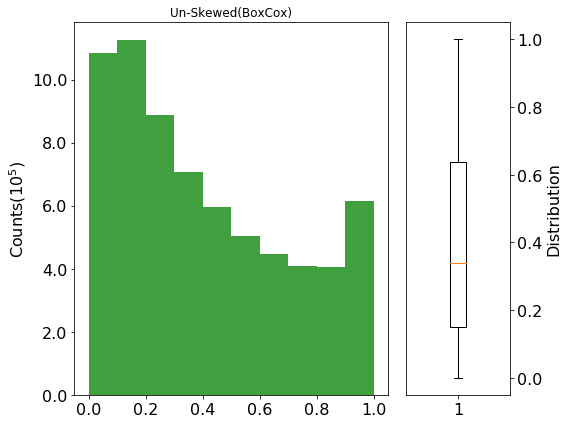

In [132]:
##We draw the histograms 
plt.clf()

# plot it
fig = plt.figure(figsize=(8, 6)) 
gs = GridSpec(1, 2, width_ratios=[3, 1])

ax1 = plt.subplot(gs[0])

plt.hist(ypred2_BoxCox_scaled,facecolor='green',alpha=0.75) 
plt.title("Un-Skewed(BoxCox)") 
ax1.yaxis.set_major_formatter(FuncFormatter(major_formatter_right))
plt.ylabel("Counts(10$^5$)") 

ax2 = plt.subplot(gs[1])

plt.boxplot(ypred2_BoxCox_scaled)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.ylabel("Distribution")

plt.tight_layout()

#plt.title("Large Skewness shows Right Skewed Distribution")
plt.savefig('./figures/fig_skewed_transform_done.png')

plt.show()



In [135]:
# print(skness_BoxCox)
# print(skness_Orig)

In [136]:
from sklearn.metrics import f1_score 

pick_entries = len(ypred2_BoxCox_scaled) ## pick a small number for testing

#Converting probabilities into 1 or 0  
ypred_final = ypred2_BoxCox_scaled[:pick_entries].copy()
dict_threshold_score = {}

threshold_list = [0.1*x for x in range(1,10)]
for current_threshold in threshold_list:
    for i in range(0, len(ypred_final)): 
        if ypred2_BoxCox_scaled[i]>=current_threshold:       # setting threshold
            ypred_final[i]=1 
        else: 
            ypred_final[i]=0
    accuracy_f1_score_xgb = f1_score(y_val[:pick_entries],ypred_final) 
    dict_threshold_score[current_threshold] = round(accuracy_f1_score_xgb, 4) 

In [176]:
# print(dict_threshold_score)

### Zoom In ###

In [168]:
from sklearn.metrics import f1_score 

pick_entries = len(ypred2_BoxCox_scaled) ## pick a small number for testing

#Converting probabilities into 1 or 0  
ypred_final = ypred2_BoxCox_scaled[:pick_entries].copy()
dict_threshold_score_zoom = {}

threshold_list_zoom = [0.8+0.02*x for x in range(0,11)]
for current_threshold in threshold_list_zoom:
    for i in range(0, len(ypred_final)): 
        if ypred2_BoxCox_scaled[i]>=current_threshold:       # setting threshold
            ypred_final[i]=1 
        else: 
            ypred_final[i]=0
    accuracy_f1_score_xgb = f1_score(y_val[:pick_entries],ypred_final) 
    dict_threshold_score_zoom[current_threshold] = round(accuracy_f1_score_xgb, 4) 

In [175]:
# print(dict_threshold_score_zoom)

In [173]:
# print(list(dict_threshold_score.values()))
# print(list(dict_threshold_score_zoom.values()))

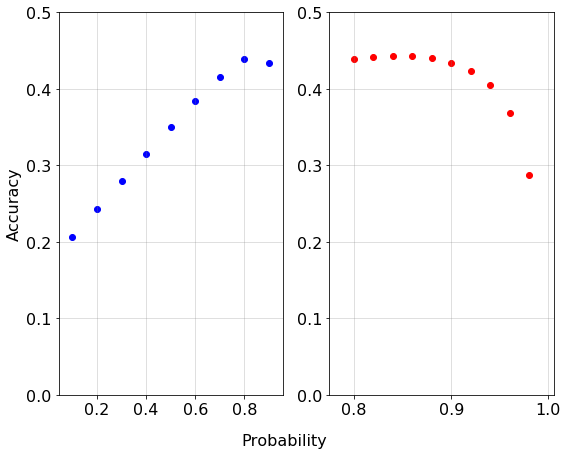

In [172]:
##We draw the histograms 
plt.clf()

# plot it
fig = plt.figure(figsize=(8, 6)) 
gs = GridSpec(1, 2, width_ratios=[1, 1])

fig.text(0.5, -0.04, 'Probability', ha='center', fontsize=16)

ax1 = plt.subplot(gs[0])
ax1.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
plt.scatter(list(dict_threshold_score.keys()), \
            list(dict_threshold_score.values()), c='b')
plt.xlabel("")
plt.ylim(0, 0.5)
plt.ylabel("Accuracy") 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

ax2 = plt.subplot(gs[1])
ax2.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
plt.scatter(list(dict_threshold_score_zoom.keys())[:-1], \
            list(dict_threshold_score_zoom.values())[:-1], c='r')
plt.xlabel("")
plt.ylabel("")
plt.ylim(0, 0.5)

plt.tight_layout()

#plt.title("Large Skewness shows Right Skewed Distribution")
plt.savefig('./figures/fig_final_pred.png')

plt.show()


| threshold | f1_score | 
|-----|------|
|0.1|0.20609277146799704|
|0.2|0.24266729790923824|
|0.3|0.27921806972672669|
|0.4|0.31480840106255714|
|0.5|0.35028018272285993|
|0.6|0.38411666111906595|
|0.7|0.41504802632773752|
|0.8|0.43878364869731834|
|0.9|0.43432638593151129|